In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

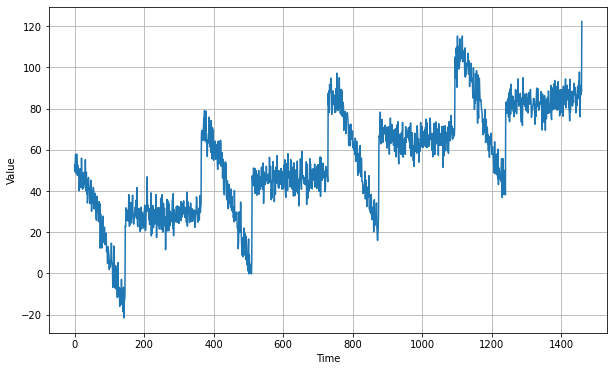

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [5]:
def sequential_window_dataset(series, window_size):
  dataset = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(dataset)
  dataset = dataset.window(window_size + 1, shift=window_size, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[1: ]))
  # batch can only be 1: on line training go through the time stamp save the last state and use it
  #    as initial state for the next batch
  return dataset.batch(1).prefetch(1)

In [10]:
for X_batch, y_batch in sequential_window_dataset(tf.range(10), 3):
    print(X_batch.numpy(), y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [19]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs):
    # clear the hidden states in the network: to make consecutive model calls independent
    self.model.reset_states()

In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(20902490)
np.random.seed(20902490)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(100, return_sequences=True, stateful=True, 
                              batch_input_shape=[1, None, 1]),
    tf.keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 200.0)           
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30)
)
reset_states = ResetStatesCallback()

model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9),
              metrics=['mae'])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule, reset_states])
                                  

Epoch 1/100
33/33 [==============================] - 4s 33ms/step - loss: 62.3699 - mae: 62.8698 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 1s 31ms/step - loss: 42.6169 - mae: 43.1158 - lr: 1.0798e-08
Epoch 3/100
33/33 [==============================] - 1s 31ms/step - loss: 32.8296 - mae: 33.3266 - lr: 1.1659e-08
Epoch 4/100
33/33 [==============================] - 1s 30ms/step - loss: 28.5401 - mae: 29.0336 - lr: 1.2589e-08
Epoch 5/100
33/33 [==============================] - 1s 31ms/step - loss: 25.9927 - mae: 26.4852 - lr: 1.3594e-08
Epoch 6/100
33/33 [==============================] - 2s 57ms/step - loss: 23.6659 - mae: 24.1595 - lr: 1.4678e-08
Epoch 7/100
33/33 [==============================] - 1s 33ms/step - loss: 21.6515 - mae: 22.1442 - lr: 1.5849e-08
Epoch 8/100
33/33 [==============================] - 1s 32ms/step - loss: 19.8838 - mae: 20.3764 - lr: 1.7113e-08
Epoch 9/100
33/33 [==============================] - 1s 32ms/step - loss: 18.3434 - mae:

(1e-08, 0.0001, 0.0, 30.0)

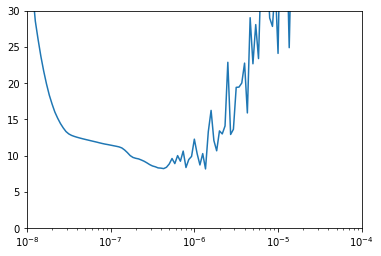

In [21]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(20902490)
np.random.seed(20902490)

train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                              batch_input_shape=[1, None, 1]),
    tf.keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x : x * 200.0)                             
])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("stateful_rnn_checkpoint.h5", 
                                                      save_best_only=True)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9),
              metrics=["mae"])

model.fit(train_set, epochs=500, validation_data=valid_set, 
          callbacks=[early_stopping, model_checkpoint, reset_states])




Epoch 1/500
33/33 [==============================] - 3s 48ms/step - loss: 44.3498 - mae: 44.8483 - val_loss: 22.5794 - val_mae: 23.0789
Epoch 2/500
33/33 [==============================] - 1s 36ms/step - loss: 24.1351 - mae: 24.6307 - val_loss: 31.8186 - val_mae: 32.3183
Epoch 3/500
33/33 [==============================] - 1s 37ms/step - loss: 15.5941 - mae: 16.0806 - val_loss: 14.7355 - val_mae: 15.2299
Epoch 4/500
33/33 [==============================] - 1s 42ms/step - loss: 12.8567 - mae: 13.3473 - val_loss: 8.3618 - val_mae: 8.8455
Epoch 5/500
33/33 [==============================] - 1s 38ms/step - loss: 10.9855 - mae: 11.4744 - val_loss: 6.7055 - val_mae: 7.1914
Epoch 6/500
33/33 [==============================] - 1s 36ms/step - loss: 10.1315 - mae: 10.6184 - val_loss: 6.4040 - val_mae: 6.8859
Epoch 7/500
33/33 [==============================] - 1s 38ms/step - loss: 9.4300 - mae: 9.9168 - val_loss: 5.9545 - val_mae: 6.4390
Epoch 8/500
33/33 [==============================] - 1s 36

In [24]:
model = tf.keras.models.load_model("stateful_rnn_checkpoint.h5")

In [25]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, : , np.newaxis]) # batch, time stamps, dim
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[0, split_time - 1: -1, 0]
print(rnn_forecast)
print(rnn_forecast.shape)

1/1 [==============================] - 0s 387ms/step
(1, 1461, 1)
[69.46827  71.29012  71.19186  69.63648  66.30062  68.68053  68.41134
 70.45879  70.64555  71.715096 67.19225  71.35851  68.74248  73.58916
 67.22115  72.6478   69.20584  66.45107  65.8045   65.54375  67.432655
 69.37491  66.471756 67.65381  72.87626  73.80253  72.003624 70.18092
 68.634315 69.4377   64.87811  66.26305  61.271255 66.29934  68.65566
 66.80473  72.44422  65.10346  62.73607  66.566124 69.17373  73.09362
 69.310036 72.04678  68.90443  67.92624  70.65513  70.5354   63.859413
 71.079346 71.88306  67.658134 70.48522  69.9301   69.15739  67.57684
 66.01416  67.08554  70.8551   70.787506 68.85737  71.131065 58.947445
 67.910995 61.123962 65.089    63.908108 62.90245  69.21889  67.405205
 69.56315  69.540955 70.11256  69.60541  65.328186 70.16926  67.163475
 63.673508 66.170944 70.9513   71.63107  70.16039  68.92971  67.68669
 73.41097  71.48355  72.08286  73.40887  71.05229  69.391785 68.9855
 68.49179  68.875626

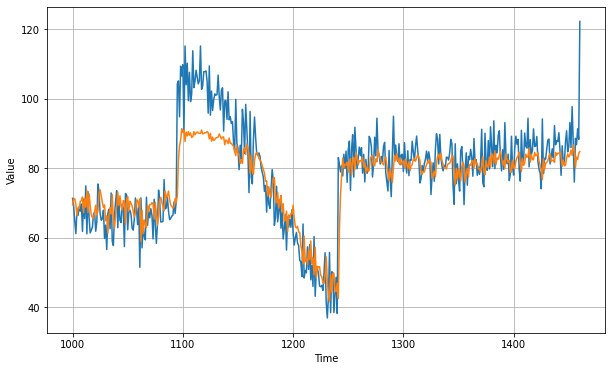

In [26]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [27]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.9912305